# Это основновной файл моей модели

Feature Name	            | Description

person_age	                | Age (Возраст)

person_income	            | Annual Income (Годовалый доход)

person_home_ownership	    | Home ownership (Владение домом)

person_emp_length	        | Employment length (in years) (Продолжительность трудовой деятельности (в годах)

loan_intent	                | Loan intent (цель предоставить кредит)

loan_grade	                | Loan grade (Кредитный рейтинг)

loan_amnt	                | Loan amount (	Сумма кредита)

loan_int_rate	            | Interest rate (Процентная ставка кредита)

loan_status	                | Loan status (0 is non default 1 is default) (Статус кредита (0 - неисполнение обязательств, 1 - неисполнение обязательств))

loan_percent_income	        | Percent income (	Процентный доход)

cb_person_default_on_file	| Historical default (Исторический дефолт) (просрочки/невыплаты по кредитам)

cb_preson_cred_hist_length	| Credit history length(Продолжительность кредитной истории)

мои импорты

In [3]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

загружаем наши данные
и сразу проверяем наши пропуски

In [4]:
df = pd.read_csv("data/credit_risk_dataset.csv")
df.head(10)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2
6,26,77100,RENT,8.0,EDUCATION,B,35000,12.42,1,0.45,N,3
7,24,78956,RENT,5.0,MEDICAL,B,35000,11.11,1,0.44,N,4
8,24,83000,RENT,8.0,PERSONAL,A,35000,8.90,1,0.42,N,2
9,21,10000,OWN,6.0,VENTURE,D,1600,14.74,1,0.16,N,3


In [5]:
# Заполним пропуски (если есть)
df["person_emp_length"] = df["person_emp_length"].fillna(df["person_emp_length"].median())
df["loan_int_rate"] = df["loan_int_rate"].fillna(df["loan_int_rate"].median())

# Категориальные признаки (CatBoost умеет работать без OneHot!)
cat_features = [
    "person_home_ownership",
    "loan_intent",
    "loan_grade",
    "cb_person_default_on_file"
]

# X и y

X = df.drop(columns=["loan_status"])
y = df["loan_status"]


# Стратифицированная кросс-валидация
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = []

for train_idx, test_idx in kfold.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
# Модель
    model = CatBoostClassifier(
        iterations=600,
        depth=8,
        learning_rate=0.05,
        loss_function='Logloss',
        verbose=0
    )

    model.fit(
        X_train, y_train,
        cat_features=cat_features
    )

    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    scores.append(acc)

print("Результаты по фолдам:", scores)
print("Средняя точность:", sum(scores) / len(scores))
print("Стандартное отклонение:", pd.Series(scores).std())

Результаты по фолдам: [0.9357066134724566, 0.9369244935543278, 0.9393799877225292, 0.9321669736034377, 0.9418354818907305]
Средняя точность: 0.9372027100486964
Стандартное отклонение: 0.0036700634850979296


In [6]:
# Сохраняем модель
model.save_model("credit_default_model.cbm")
print("Модель сохранена!")

Модель сохранена!


                       feature  importance
8          loan_percent_income   19.923159
2        person_home_ownership   17.847042
1                person_income   15.346880
5                   loan_grade   13.923753
4                  loan_intent   12.370354
3            person_emp_length    5.858647
7                loan_int_rate    4.890349
6                    loan_amnt    3.604270
0                   person_age    3.571108
10  cb_person_cred_hist_length    1.927774
9    cb_person_default_on_file    0.736663


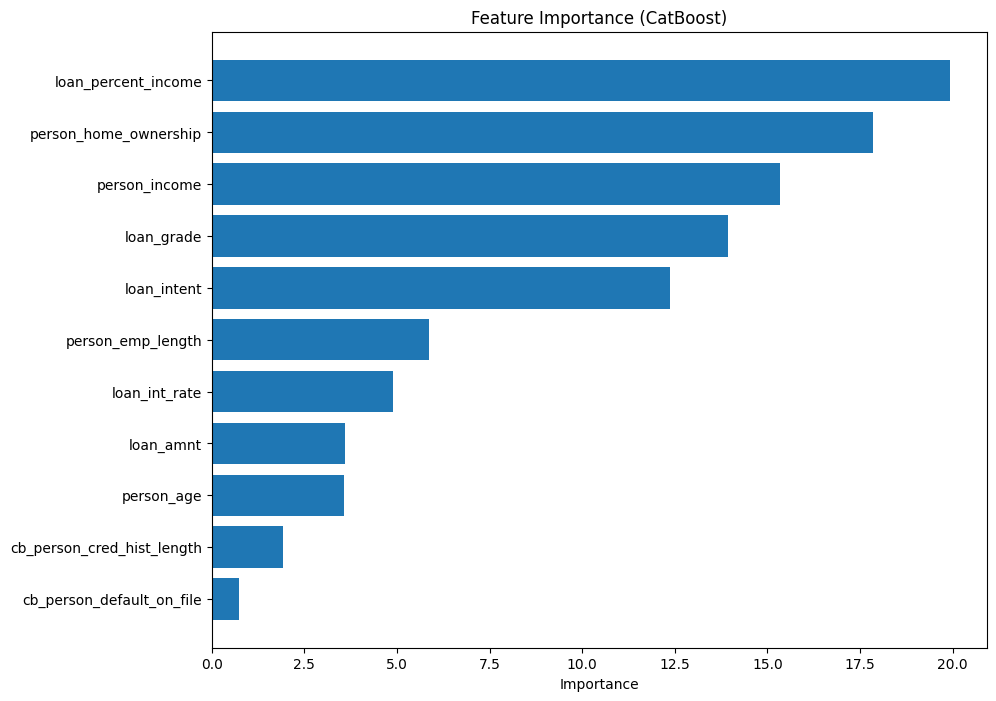

In [7]:
# Используем последнюю обученную модель из цикла
# CatBoost имеет атрибут feature_importances_
importance = model.get_feature_importance()
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': importance
}).sort_values(by='importance', ascending=False)

# Вывод таблицы
print(feature_importance)

# График значимости
plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.gca().invert_yaxis()
plt.title("Feature Importance (CatBoost)")
plt.xlabel("Importance")
plt.show()